In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
from sklearn import linear_model
%matplotlib inline
import mwviews
from bs4 import BeautifulSoup
import requests
from mwviews.api import PageviewsClient

### Scraping class

In [4]:
class scrape_title_info:
    def __init__(self):
        self.wiki_titles = []
        self.wiki_urls = []
        self.list_dicts = []
        self.wiki_api_titles = []
        self.title_list = []
        self.rottentomatoes_scores = []
        self.metacritic_scores = []
        self.bomojo_info = []

    
    # fit function to run all other functions with status updates through process
    def fit(self,start_year,end_year):
        print('Getting links...')
        self.get_links(start_year,end_year)
        print('Getting wikipedia info from wiki pages...')
        self.get_wiki_info()
        print('Cleaning wikipedia urls...')
        self.clean_wiki_urls()
        print('Setting up early dataframes...')
        self.data_frames_early()
        print('Getting wikipedia search volume...')
        self.get_wiki_search_vol()
        print('Getting box office mojo information...')
        self.bomojo()
        print('Getting rottentomatoes scores...')
        self.get_rotten_tomatoes()
        print('Getting metacritic scores...')
        self.get_metacritics_score()
        print('Setting up final dataframes...')
        self.data_frames_final()
        print('Completed!')
    
    
    def get_links(self,start_year,end_year):
        for year in range(start_year,end_year + 1):
            url = 'https://en.wikipedia.org/wiki/' + str(year) + '_in_film'
            result = requests.get(url)
            soup = BeautifulSoup(result.content)
            links = soup.find_all("table", { "class" : "wikitable sortable" })

            for link in links:
                for lin in link.find_all('i'):
                    for i in lin.find_all('a'):
                        self.wiki_titles.append(i.get_text())
                        self.wiki_urls.append(i.get('href'))
 

    def get_wiki_info(self):
        for url in self.wiki_urls:
            site_url = 'https://en.wikipedia.org/' + url 
            result = requests.get(site_url)
            soup = BeautifulSoup(result.content)
            info = soup.find_all('table', {'class': 'infobox'})

            # get category title like directed by, studio, boxoffice, etc.
            # categories differ by title/url so I can't just ask for the 5th or 6th element to get what I want
            category_info = []
            try:
                category = info[0].find_all('th', {'scope' : 'row'})
                for cat in category:
                    category_info.append(cat.get_text(strip=True))
            except:
                category_info.append(None)

            # get the actual information associated with each category
            summary_info = []
            try:
                information = info[0].find_all('td')[1:]
                for inf in information:
                    summary_info.append(inf.get_text('|',strip=True))
            except:
                summary_info.append(None)
            # add list items to dictionary to re-create structure from wikipedia
            dictionary = dict(zip(category_info, summary_info))
            dictionary['wiki_url'] = url 

            # get external links for bomojo, imdb, metacritic, rottentomatoes for each title and add it to dictionary
            ext_text = soup.find_all('a', {'class': 'external text'})
            ext_links = []
            for ext in ext_text:
                ext_links.append(ext.get('href'))

            # ad hoc way to parse out links for each title and site
            for link in ext_links:
                if 'mojo' in link:
                    if 'movies' in link:
                        dictionary['bomojo_link'] = link
                    else:
                        pass
                elif 'rottentomatoes' in link:
                    if 'editorial' in link:
                        pass
                    elif 'archive' in link:
                        pass
                    else:
                        dictionary['rottentomatoes_link'] = link
                elif 'metacritic' in link:
                    if 'user' in link:
                        pass
                    elif 'imdb' in link:
                        pass
                    elif 'rotten' in link:
                        pass
                    elif 'archive' in link:
                        pass
                    else:
                        dictionary['metacritic_link'] = link
                elif 'imdb' in link:
                    if 'soundtrack' in link:
                        pass
                    elif 'metacritic' in link:
                        pass
                    elif 'rotten' in link:
                        pass
                    elif 'archive' in link:
                        pass
                    else:
                        dictionary['imdb_link'] = link
                else:
                    pass

            self.list_dicts.append(dictionary)  

    # remove wikipedia characters in url so the wiki api can read the titles appropriately
    def clean_wiki_urls(self):    
        for url in self.wiki_urls:
            org_url = url
            url = url.replace('%27', "'")
            url = url.replace('%26', '&')
            url = url.replace('%28', '(')
            url = url.replace('%29', ')')
            url = url.replace('%3F', '?')
            url = url.replace('%E2%80%93', '-')
            url = url.replace('%C3%A9', 'é')
            url = url.replace('%C3%A8', 'è')
            url = url.replace('%2C', ',')
            url = url.replace('%C4%97', 'ė')
            url = url.replace('%C3%A0', 'à')
            url = url.replace('%C3%BC', 'ü')
            url = url.replace('%C3%A1', 'á')
            self.wiki_api_titles.append((org_url,url[6:]))

    def data_frames_early(self):
        #create dataframe for wiki link and titles, not really needed, might remove
        self.df_wiki_links = pd.DataFrame({'wiki_title': self.wiki_titles,
                                           'wiki_url': self.wiki_urls})
        df_wiki_links_clean = pd.DataFrame(self.wiki_api_titles,columns=['org_wiki_url','clean_wiki_url'])
        self.df_wiki_links = self.df_wiki_links.merge(df_wiki_links_clean,left_on='wiki_url',right_on='org_wiki_url',how='left')
        self.df_wiki_links.to_csv('wikipedia_links.csv',sep=',',index=False)
        
        #create dataframe of wikipedia info, needed for bomojo, rottentomatoes and metacritic scrapes
        self.df_wiki_info = pd.DataFrame(self.list_dicts)
        self.df_wiki_info = self.df_wiki_info[['wiki_url','Country','Directed by','Distributed by',
                                               'Distributor','Genre','Produced by','Producer(s)',
                                               'Productioncompanies','Productioncompany','Productioncompany(s)',
                                               'Release date','Released','Length','Running time','Website',
                                               'Box office','Budget','Written by',
                                               'bomojo_link','imdb_link','metacritic_link', 'rottentomatoes_link']]
        self.df_wiki_info.merge(self.df_wiki_links,left_on='wiki_url',right_on='wiki_url',how='left')
        self.df_wiki_info.to_csv('wikipedia_page_info.csv',sep=',',index=False)
        # remove titles that don't have links to bomojo, rottentomatoes, and metacritic
        self.df_wiki_info = self.df_wiki_info.dropna(subset=['bomojo_link','rottentomatoes_link','metacritic_link'])
        
    
    # with clean urls, run each title through wikipedia api to get search volume
    def get_wiki_search_vol(self):
        p = PageviewsClient(user_agent="<person@organization.org> multiple movie titles")
        for title in self.df_wiki_links.clean_wiki_url:
            try:
                title_dict = p.article_views('en.wikipedia', title,start='19980101',end='20191231')
            except:
                None
            self.title_list.append(title_dict)

    # bomojo scrape to get film performance and cleaner release date
    # an issue with some titles where the initial info with release date, distributor, etc. is shifted
    # need to revisit to fix so as not to lose films like Avatar, Harry Potter 7, Lion King, and a few others
    def bomojo(self):
        for url in self.df_wiki_info.bomojo_link:
            try:
                result = requests.get(url)
                soup = BeautifulSoup(result.content)
                figures = soup.find_all('div', {'class': 'mp_box_content'})

                self.bomojo_info.append((url  #bomojo url as primary key
                                         ,soup.find_all('b')[1].get_text(strip=True) #title
                                        ,soup.find_all('b')[5].get_text(strip=True) #genre
                                        ,soup.find_all('b')[4].get_text(strip=True) #domestic release date
                                        ,soup.find_all('b')[7].get_text(strip=True) #rating
                                        ,soup.find_all('b')[3].get_text(strip=True) #studio/distributor
                                        ,figures[0].find_all('b')[1].get_text(strip=True) #domestic box office
                                        ,figures[0].find_all('b')[4].get_text(strip=True) #ww box office
                                        ,figures[1].find_all('td')[1].get_text(strip=True) #opening weekend dom box office
                                        ,figures[1].find_all('td')[7].get_text(strip=True))) # widest release # theaters
            except:
                self.bomojo_info.append((url, None, None, None, None, None, None, None, None, None))

                
    def get_rotten_tomatoes(self):
        self.rt_links = [link for link in list(self.df_wiki_info.rottentomatoes_link) if '/m/' in link]
        self.rt_links = set(self.rt_links) 
        
        for url in self.rt_links:
            if url.endswith("/"):
                url_top = url + 'reviews/?type=top_critics'
            else:
                url_top = url + '/reviews/?type=top_critics'
            try:
                result = requests.get(url_top)
                soup = BeautifulSoup(result.content)
                figures = soup.find_all('div', {'class': 'review_table'})

                names = figures[0].find_all('div', {'class': 'critic_name'}) # name of people and journal
                dates = figures[0].find_all('div',{'class': 'review_date subtle small'}) # review date
                review_icons = figures[0].find_all('div',{'class': 'review_icon'})

                for name, date, icon in zip(names,dates,review_icons):
                    name.find_all('a')
                    self.rottentomatoes_scores.append((url, name.get_text("|",strip=True),
                                                  date.get_text(strip=True),icon.get('class')[3]))
            except:
                self.rottentomatoes_scores.append((url, None, None, None))

        
    def get_metacritics_score(self):
        urls = list(set(self.df_wiki_info.metacritic_link))
        for url in urls:
            if url.endswith("/"):
                url_review = url + 'critic-reviews'
            else:
                url_review = url + '/critic-reviews'
            try:
                headers = {'User-Agent': 'Mozilla/5.0'}
                result = requests.get(url_review, headers=headers)
                soup = BeautifulSoup(result.content)

                scores = soup.find_all('div', {'class': 'metascore_w'}) 
                dates = soup.find_all('span', {'class': 'date'})
                
                if not dates:
                    for score in scores:
                        self.metacritic_scores.append((url, None, score.get_text(strip=True)))
                else:
                    for date, score in zip(dates,scores):
                        self.metacritic_scores.append((url, date.get_text(strip=True),score.get_text(strip=True)))
            except:
                self.metacritic_scores.append((url, None, None))

                
    def data_frames_final(self):
        df_wiki_search_vol = pd.concat([
            pd.DataFrame.from_dict(title_dict,orient='index')
            for title_dict in self.title_list
        ], axis=1,sort=False)
        df_wiki_search_vol.to_csv('wikipedia_search_volume.csv',index=True)
        
        df_bomojo = pd.DataFrame(data=self.bomojo_info,columns=['bomojo_url','bomojo_title','bomojo_genre', 
                                                   'bomojo_dom_releasedate','bomojo_mpaa_rating', 'bomojo_distributor',
                                                   'bomojo_dom_boxoffice','bomojo_ww_boxoffice', 
                                                   'bomojo_opwkd_dom_boxoffice','bomojo_numtheatres'])
        df_bomojo.to_csv('bomojo_data.csv',index=False)
        
        df_rottentomatoes = pd.DataFrame(data=self.rottentomatoes_scores, columns = ['rt_url','rt_critic|journal','rt_date','rt_review'])
        df_rottentomatoes.to_csv('rottentomatoes_score_data.csv',sep=',',index=False)
        
        df_metacritic = pd.DataFrame(data=self.metacritic_scores, columns=['mc_url','mc_date','mc_score'])
        df_metacritic.to_csv('metacritic_score_info.csv',sep=',',index=False)        

In [5]:
scraper = scrape_title_info()
scraper.fit(2012,2018)

Getting links...
Getting wikipedia info from wiki pages...
Cleaning wikipedia urls...
Setting up early dataframes...
Getting wikipedia search volume...
Getting box office mojo information...
Getting rottentomatoes scores...
Getting metacritic scores...
Setting up final dataframes...
Completed!


### Cleaning class

In [2]:
# import csv with wiki titles and urls
df_wiki_links = pd.read_csv('wikipedia_links.csv')
# import csv with wikipedia information, plus links to bomojo, RT, and metacritic
df_wiki_info = pd.read_csv('wikipedia_page_info.csv')

In [3]:
# import csv file with ratings from both RT and metacritic
df_rottentomatoes = pd.read_csv('rottentomatoes_score_info.csv')
df_metacritic = pd.read_csv('metacritic_score_info.csv')

In [4]:
# import csv file with bomojo box office information for each
df_bomojo = pd.read_csv('bomojo_data.csv')

In [5]:
# import csv file with wikipedia search volume for each title
df_wiki_search_vol = pd.read_csv('wikipedia_search_volume.csv',index_col=0)

In [6]:
df_wiki_info = df_wiki_info.merge(df_wiki_links,left_on='wiki_url',right_on='wiki_url')

In [7]:
df_bomojo['bomojo_dom_releasedate'] = pd.to_datetime(df_bomojo['bomojo_dom_releasedate'],errors='coerce')

In [8]:
df_bomojo[df_bomojo.columns[5:8]] = df_bomojo[df_bomojo.columns[5:8]].replace('[\$,]', '', regex=True)
df_bomojo['bomojo_dom_boxoffice'] = pd.to_numeric(df_bomojo['bomojo_dom_boxoffice'],errors='coerce')
df_bomojo['bomojo_ww_boxoffice'] = pd.to_numeric(df_bomojo['bomojo_ww_boxoffice'],errors='coerce')
df_bomojo['bomojo_opwkd_dom_boxoffice'] = pd.to_numeric(df_bomojo['bomojo_opwkd_dom_boxoffice'],errors='coerce')

In [9]:
df_bomojo['bomojo_numtheatres_norm'] = df_bomojo['bomojo_numtheatres'].replace(' theaters', '', regex=True)
df_bomojo['bomojo_numtheatres_norm'] = df_bomojo['bomojo_numtheatres_norm'].replace(',', '', regex=True)
df_bomojo['bomojo_numtheatres_norm'] = pd.to_numeric(df_bomojo['bomojo_numtheatres_norm'],errors='coerce')

In [10]:
df_rottentomatoes = pd.get_dummies(data=df_rottentomatoes, columns=['review'])
df_rottentomatoes_scores = df_rottentomatoes[['rt_url','review_fresh']].groupby(['rt_url'],as_index=False).mean()

In [11]:
df_metacritic['mc_score'] = pd.to_numeric(df_metacritic['mc_score'],errors='coerce')
df_metacritic_scores = df_metacritic.groupby(['mc_url'],as_index=False).mean()

In [12]:
avg_search_vol = df_wiki_search_vol.mean(axis=0)
max_search_vol = df_wiki_search_vol.max(axis=0)
median_search_vol = df_wiki_search_vol.median(axis=0)
std_search_vol = df_wiki_search_vol.std(axis=0)
df_search_features = pd.DataFrame({'avg_search_vol': avg_search_vol, 
                                   'max_search_vol': max_search_vol,
                                   'median_search_vol': median_search_vol,
                                   'std_search_vol': std_search_vol})

In [13]:
df_bo_predictor = df_wiki_info.merge(df_rottentomatoes_scores,left_on='rottentomatoes_link',right_on='rt_url',how='left')
df_bo_predictor = df_bo_predictor.merge(df_metacritic_scores,left_on='metacritic_link',right_on='mc_url',how='left')
df_bo_predictor = df_bo_predictor.merge(df_bomojo,left_on='bomojo_link',right_on='bomojo_url',how='left')
df_bo_predictor = df_bo_predictor.merge(df_search_features,left_on='clean_wiki_url',right_index=True,how='left')

In [14]:
df_bo_predictor.describe()

,review_fresh,mc_score,bomojo_dom_boxoffice,bomojo_ww_boxoffice,bomojo_opwkd_dom_boxoffice,bomojo_numtheatres_norm,avg_search_vol,max_search_vol,median_search_vol,std_search_vol
count,1765.000000,1643.000000,1.243000e+03,1.243000e+03,0.0,1080.000000,2266.000000,2.266000e+03,2266.000000,2265.000000
mean,0.507984,60.583639,5.331462e+07,1.361299e+08,NaN,2132.792593,1974.669241,3.766270e+04,1196.681818,2877.342100
std,0.321719,15.697147,8.764379e+07,2.347581e+08,NaN,1462.809680,3439.815501,1.021428e+05,1856.423232,6936.527465
min,0.000000,7.400000,7.420000e+02,8.370000e+02,NaN,1.000000,1.000000,1.000000e+00,1.000000,0.000000
25%,0.208333,49.633333,3.128357e+06,8.413144e+06,NaN,355.000000,330.794523,3.262250e+03,249.000000,254.761111
50%,0.536585,60.681818,2.157119e+07,4.449528e+07,NaN,2622.000000,943.551036,1.069550e+04,657.000000,874.302392
75%,0.787879,72.461799,6.063891e+07,1.459995e+08,NaN,3355.000000,2012.999041,2.844150e+04,1391.000000,2313.360316
max,1.000000,97.480000,9.366622e+08,2.187464e+09,NaN,4485.000000,70373.600000,1.790893e+06,43743.500000,99587.889634


In [15]:
df_bo_predictor = df_bo_predictor.dropna(subset=['bomojo_dom_boxoffice','mc_score','review_fresh','bomojo_dom_releasedate'])

In [16]:
df_bo_predictor = df_bo_predictor.drop_duplicates(subset='wiki_url') 

In [17]:
df_bo_predictor.describe()

,review_fresh,mc_score,bomojo_dom_boxoffice,bomojo_ww_boxoffice,bomojo_opwkd_dom_boxoffice,bomojo_numtheatres_norm,avg_search_vol,max_search_vol,median_search_vol,std_search_vol
count,1043.000000,1043.000000,1.043000e+03,1.043000e+03,0.0,922.000000,1043.000000,1.043000e+03,1043.000000,1043.000000
mean,0.500400,58.995135,5.677302e+07,1.408850e+08,NaN,2352.584599,2714.813829,5.112558e+04,1638.332694,3950.834816
std,0.309094,15.642819,8.124199e+07,2.237825e+08,NaN,1367.192975,3536.988452,1.223737e+05,1854.751857,7747.866513
min,0.000000,16.875000,7.420000e+02,8.370000e+02,NaN,1.000000,21.701458,7.500000e+01,3.000000,9.975503
25%,0.214286,47.308761,6.704091e+06,1.392691e+07,NaN,1063.250000,723.175757,7.865000e+03,542.000000,554.022341
50%,0.512195,58.866667,2.884224e+07,5.288202e+07,NaN,2818.500000,1539.451266,1.904600e+04,1103.000000,1439.620764
75%,0.777778,70.352529,6.776772e+07,1.617373e+08,NaN,3391.000000,3264.608549,4.399850e+04,2074.500000,3885.192425
max,1.000000,97.480000,6.788155e+08,2.048360e+09,NaN,4485.000000,31386.618573,1.790893e+06,13345.000000,99587.889634


In [18]:
df_bo_predictor.head()

,wiki_url,Country,Directed by,Distributed by,Distributor,Genre,Produced by,Producer(s),Productioncompanies,Productioncompany,...,bomojo_distributor,bomojo_dom_boxoffice,bomojo_ww_boxoffice,bomojo_opwkd_dom_boxoffice,bomojo_numtheatres,bomojo_numtheatres_norm,avg_search_vol,max_search_vol,median_search_vol,std_search_vol
3,/wiki/Contraband_(2012_film),United States|United Kingdom,Baltasar Kormákur,Universal Pictures,NaN,NaN,Tim Bevan|Eric Fellner|Baltasar Kormákur|Steph...,NaN,NaN,Relativity Media|Working Title Films|Blueeyes ...,...,Universal,66528000.0,96262212.0,NaN,"2,870 theaters",2870.0,559.566385,6292.0,459.0,415.175167
4,/wiki/Joyful_Noise_(film),United States,Todd Graff,Warner Bros.,NaN,NaN,Broderick Johnson|Andrew Kosove|Michael Nathan...,NaN,NaN,Alcon Entertainment,...,Warner Bros.,30932113.0,31158113.0,NaN,"2,735 theaters",2735.0,350.241750,2372.0,299.0,202.372083
10,/wiki/Haywire_(2011_film),United States,Steven Soderbergh,Relativity Media,NaN,NaN,Gregory Jacobs,NaN,NaN,Relativity Media,...,Relativity,18942396.0,33372606.0,NaN,"2,441 theaters",2441.0,380.624413,1604.0,321.0,195.842928
11,/wiki/Red_Tails,United States,Anthony Hemingway,20th Century Fox,NaN,NaN,Rick McCallum|Charles Floyd Johnson,NaN,NaN,Lucasfilm Ltd.,...,Fox,49876377.0,50365377.0,NaN,"2,573 theaters",2573.0,835.865695,6848.0,698.0,533.780895
12,/wiki/Underworld:_Awakening,United States,Måns Mårlind|Björn Stein,Screen Gems,NaN,NaN,Tom Rosenberg|Gary Lucchesi|Len Wiseman|Richar...,NaN,NaN,Lakeshore Entertainment|Sketch Films,...,Sony / Screen Gems,62321039.0,160112671.0,NaN,"3,078 theaters",3078.0,1418.586339,22843.0,1074.0,1339.940549


In [19]:
df_wiki_search_vol.index = pd.to_datetime(df_wiki_search_vol.index)

In [20]:
# feature: 1 month search volume, 6 months prior to release
# feature: 1 month search volume, 5 months prior to release
# feature: 1 month search volume, 4 months prior to release
# feature: 1 month search volume, 3 months prior to release
# feature: 1 month search volume, 2 months prior to release
# feature: 1 month search volume, 1 month prior to release
# feature: average growth / change % between 6 months above 

# feature: 1 week search volume, 4 weeks prior to release
# feature: 1 week search volume, 3 weeks prior to release
# feature: 1 week search volume, 2 weeks prior to release
# feature: 1 week search volume, 1 week prior to release
# feature: average growth / change % between 4 weeks above

# feature: search volume on the day 1 week before release

#### Follow-up: How to get search volume from wikipedia prior to July 2015?

In [21]:
list_dicts = []

def consolidate_search(urls):
        
    for title in list(urls):
        series = df_wiki_search_vol[title]
        release_date = df_bo_predictor[df_bo_predictor['clean_wiki_url'] == title]['bomojo_dom_releasedate'].values[0]
        row = {}
        row['title'] = title
        for week in [1,2,3,4,5]:
            date_range = pd.date_range(start = (release_date - pd.Timedelta(days=(week+1)*7-1)),end = (release_date - pd.Timedelta(days=(week+1)*7-7)))                
            subset = series.loc[date_range]
            if len(subset) > 0:
                row[f'mean_week_{week}'] = subset.mean()
                row[f'max_week_{week}'] = subset.max()
                row[f'median_week_{week}'] = subset.median()
                row[f'std_week_{week}'] = subset.std()
            else:
                None
        for month in [1,2,3,4,5,6]:
            date_range = pd.date_range(start = (release_date - pd.Timedelta(days=month*30-1)),end = (release_date - pd.Timedelta(days=month*30-30)))
            subset = series.loc[date_range]
            if len(subset) > 0:
                row[f'mean_month_{month}'] = subset.mean()
                row[f'max_month_{month}'] = subset.max()
                row[f'median_month_{month}'] = subset.median()
                row[f'std_month_{month}'] = subset.std()
            else:
                None
        list_dicts.append(row)


In [22]:
consolidate_search(df_bo_predictor.clean_wiki_url)

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [23]:
df_search = pd.concat([pd.DataFrame(item,index=[0]) for item in list_dicts
                      ],ignore_index=True)

In [24]:
# # original script working off of before specifying below
# for movie_title in titles: 
#     series = search_df[movie_title]
#     for week in [1,2,3,4]:
#         date_range = pd.date_range(start=release_date - td(week*7),end=release_date - td(week*7-6))
#         subset = series.loc[date_range]
#         new_df['mean_week_1'] = subset.mean()
#         ...
        
#         # movie_id  mean_week_1  mean_week_2  mean_month_1
#         # Titanic   65           14           252
        

In [25]:
df_bo_predictor = df_bo_predictor.merge(df_search,left_on='clean_wiki_url',right_on='title',how='left')

In [26]:
df_bo_predictor.columns

Index(['wiki_url', 'Country', 'Directed by', 'Distributed by', 'Distributor',
       'Genre', 'Produced by', 'Producer(s)', 'Productioncompanies',
       'Productioncompany', 'Productioncompany(s)', 'Release date', 'Released',
       'Length', 'Running time', 'Website', 'Box office', 'Budget',
       'Written by', 'bomojo_link', 'imdb_link', 'metacritic_link',
       'rottentomatoes_link', 'wiki_title', 'org_wiki_url', 'clean_wiki_url',
       'rt_url', 'review_fresh', 'mc_url', 'mc_score', 'bomojo_url',
       'bomojo_title', 'bomojo_genre', 'bomojo_dom_releasedate',
       'bomojo_mpaa_rating', 'bomojo_distributor', 'bomojo_dom_boxoffice',
       'bomojo_ww_boxoffice', 'bomojo_opwkd_dom_boxoffice',
       'bomojo_numtheatres', 'bomojo_numtheatres_norm', 'avg_search_vol',
       'max_search_vol', 'median_search_vol', 'std_search_vol', 'title',
       'mean_week_1', 'max_week_1', 'median_week_1', 'std_week_1',
       'mean_week_2', 'max_week_2', 'median_week_2', 'std_week_2',
       'm

In [27]:
df_bo_predictor = df_bo_predictor.dropna(subset=['mean_week_1',
       'max_week_1', 'median_week_1', 'std_week_1', 'mean_week_2',
       'max_week_2', 'median_week_2', 'std_week_2', 'mean_week_3',
       'max_week_3', 'median_week_3', 'std_week_3', 'mean_week_4',
       'max_week_4', 'median_week_4', 'std_week_4', 'mean_week_5',
       'max_week_5', 'median_week_5', 'std_week_5', 'mean_month_1',
       'max_month_1', 'median_month_1', 'std_month_1'])

In [28]:
df_bo_predictor = df_bo_predictor.drop_duplicates(subset='wiki_url') 

In [29]:
df_bo_predictor.describe()

,review_fresh,mc_score,bomojo_dom_boxoffice,bomojo_ww_boxoffice,bomojo_opwkd_dom_boxoffice,bomojo_numtheatres_norm,avg_search_vol,max_search_vol,median_search_vol,std_search_vol,...,median_month_4,std_month_4,mean_month_5,max_month_5,median_month_5,std_month_5,mean_month_6,max_month_6,median_month_6,std_month_6
count,494.000000,494.000000,4.940000e+02,4.940000e+02,0.0,436.000000,494.000000,4.940000e+02,494.000000,494.000000,...,448.00000,448.000000,413.000000,413.000000,413.000000,410.000000,376.000000,376.000000,376.000000,376.000000
mean,0.515813,59.094093,5.950397e+07,1.498573e+08,NaN,2509.896789,4135.041729,8.741224e+04,2206.519231,7003.141633,...,2307.63058,1880.193881,2879.728482,10428.285714,2203.817191,2011.267638,2788.409057,10454.577128,2096.155585,2057.212058
std,0.311874,15.940327,9.054799e+07,2.443921e+08,NaN,1322.847396,4490.621403,1.674726e+05,2306.717421,10276.007002,...,2920.38438,4174.094681,4634.348103,27436.797442,3189.034423,5786.743675,4884.655016,28464.732012,3216.692256,6088.776704
min,0.000000,18.000000,7.420000e+02,3.633600e+04,NaN,6.000000,64.128874,4.330000e+02,3.000000,36.442917,...,1.50000,0.811177,1.470588,3.000000,1.000000,0.624264,1.000000,1.000000,1.000000,0.000000
25%,0.250000,46.889130,7.104096e+06,1.481527e+07,NaN,1761.000000,1422.338718,1.783500e+04,810.500000,1760.572164,...,677.12500,155.030722,581.142857,917.000000,539.500000,103.870267,485.550000,782.500000,435.875000,73.796011
50%,0.520870,59.101010,2.917649e+07,5.481335e+07,NaN,2906.000000,2634.796623,3.632900e+04,1516.250000,3624.394831,...,1428.00000,434.329188,1368.533333,2474.000000,1192.500000,284.428081,1204.783333,1987.000000,1119.750000,220.285475
75%,0.798864,70.791229,6.762621e+07,1.623070e+08,NaN,3511.750000,4957.252302,8.461475e+04,2633.000000,7615.990307,...,2857.87500,1514.159216,3180.466667,7742.000000,2348.500000,1342.110591,2660.091667,6017.500000,2202.625000,1082.903724
max,1.000000,96.245283,6.788155e+08,2.048360e+09,NaN,4485.000000,31386.618573,1.790893e+06,13345.000000,99587.889634,...,21601.50000,40380.980552,42504.300000,307724.000000,24957.500000,65222.257081,36850.066667,282503.000000,24081.500000,59545.859700


In [30]:
# adding some additional features to search volume
df_bo_predictor['max_mean_weekly_search_vol'] = df_bo_predictor[['mean_week_1','mean_week_2','mean_week_3',
                                                                 'mean_week_4','mean_week_5']].max(axis=1)
df_bo_predictor['mean_mean_weekly_search_vol'] = df_bo_predictor[['mean_week_1','mean_week_2','mean_week_3',
                                                                  'mean_week_4','mean_week_5']].mean(axis=1)
df_bo_predictor['max_max_weekly_search_vol'] = df_bo_predictor[['max_week_1','max_week_2','max_week_3',
                                                                'max_week_4','max_week_5']].max(axis=1)
df_bo_predictor['mean_max_weekly_search_vol'] = df_bo_predictor[['max_week_1','max_week_2','max_week_3',
                                                                'max_week_4','max_week_5']].mean(axis=1)
df_bo_predictor['mean_median_weekly_search_vol'] = df_bo_predictor[['median_week_1','median_week_2','median_week_3',
                                                                'median_week_4','median_week_5']].mean(axis=1)
df_bo_predictor['max_median_weekly_search_vol'] = df_bo_predictor[['median_week_1','median_week_2','median_week_3',
                                                                'median_week_4','median_week_5']].max(axis=1)

### Analyzing data

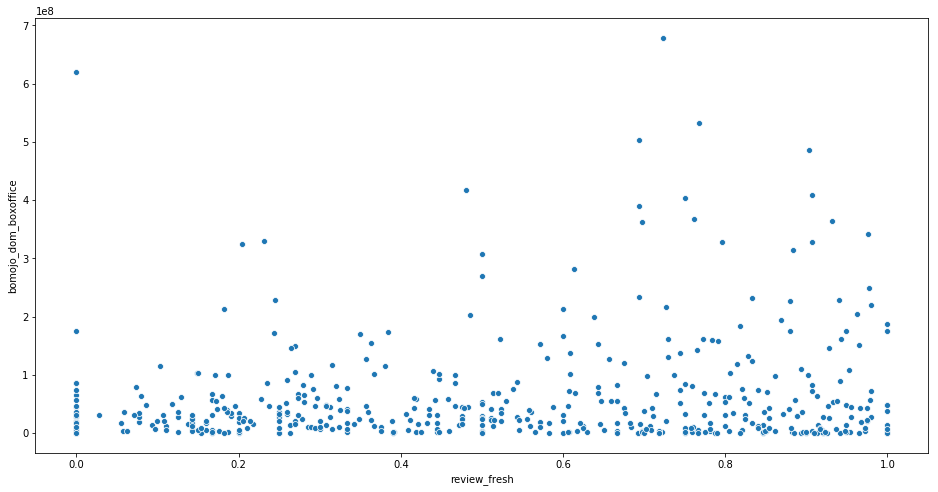

In [31]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='review_fresh',y='bomojo_dom_boxoffice',data=df_bo_predictor)
plt.show()

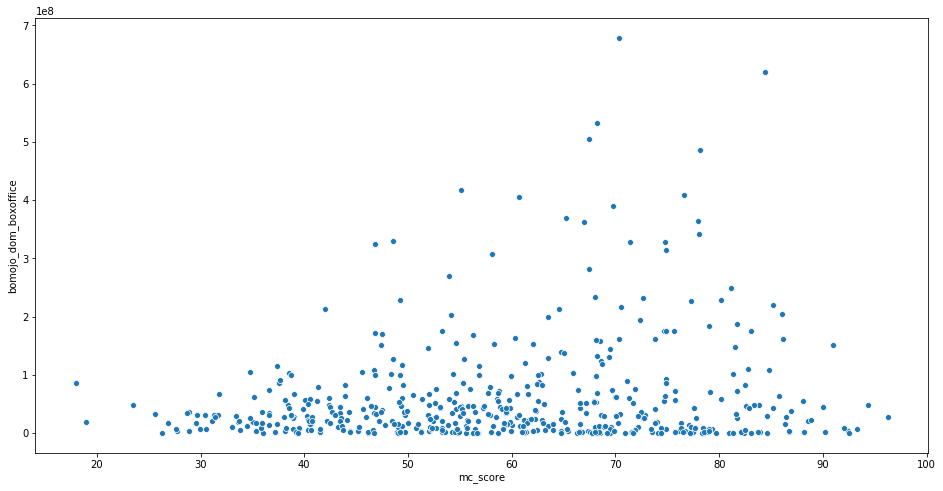

In [32]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='mc_score',y='bomojo_dom_boxoffice',data=df_bo_predictor)
plt.show()

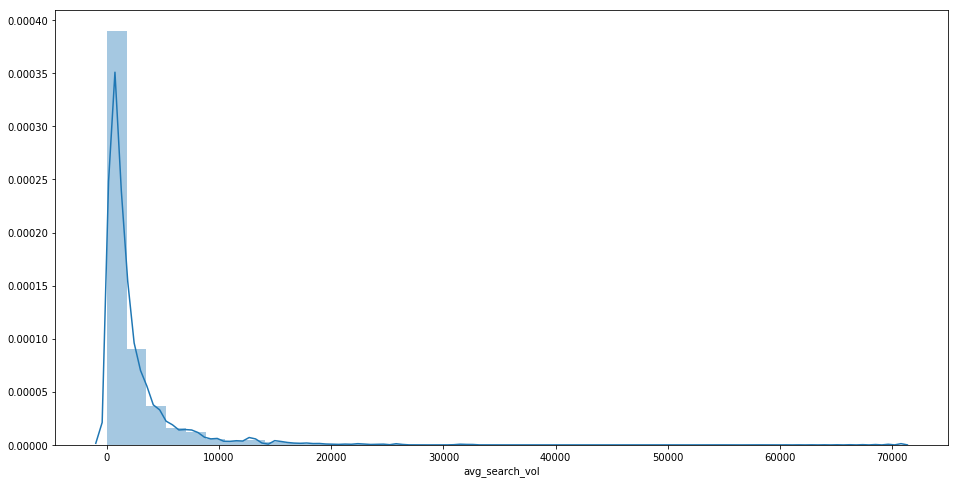

In [33]:
plt.figure(figsize=(16,8))
sns.distplot(df_search_features.avg_search_vol,bins=40)
plt.show()

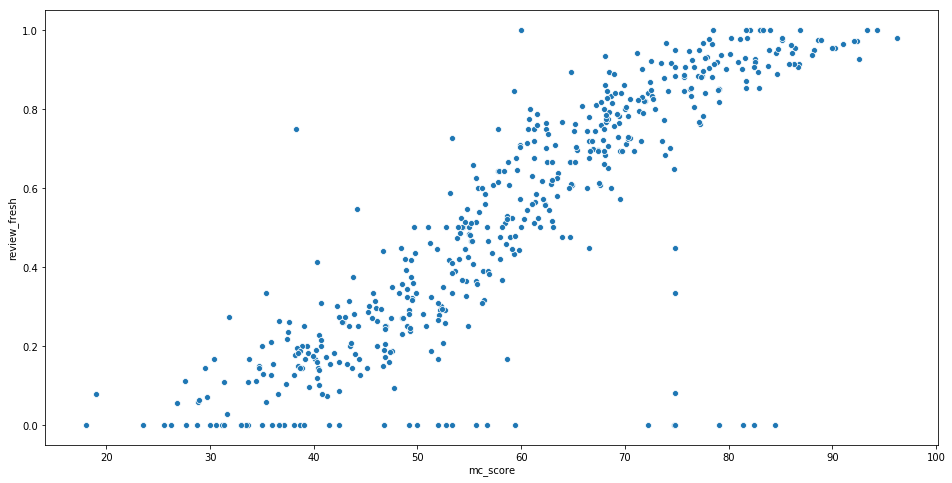

In [34]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='mc_score',y='review_fresh',data=df_bo_predictor)
plt.show()

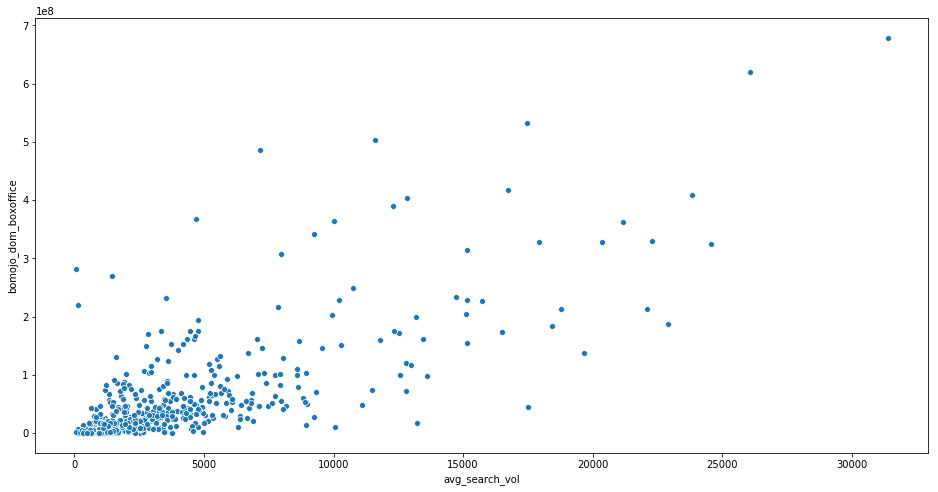

In [35]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='avg_search_vol',y='bomojo_dom_boxoffice',data=df_bo_predictor)
plt.show()

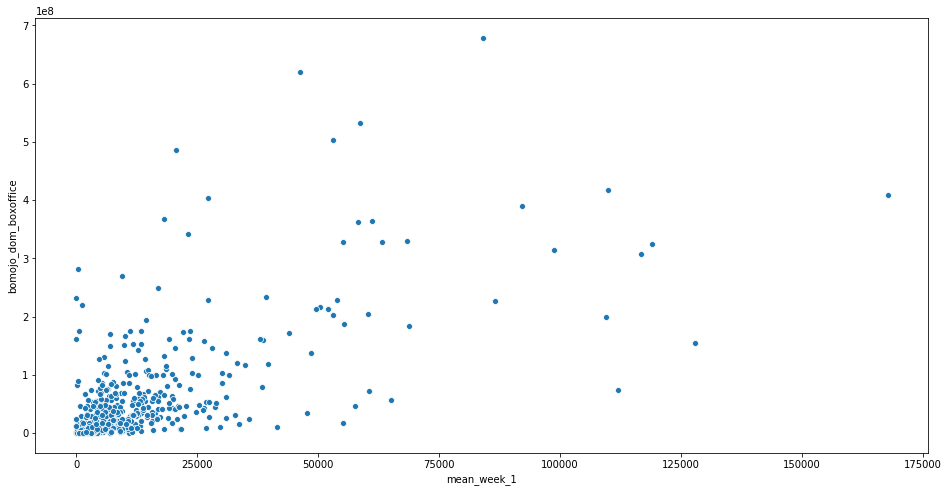

In [36]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='mean_week_1',y='bomojo_dom_boxoffice',data=df_bo_predictor)
plt.show()

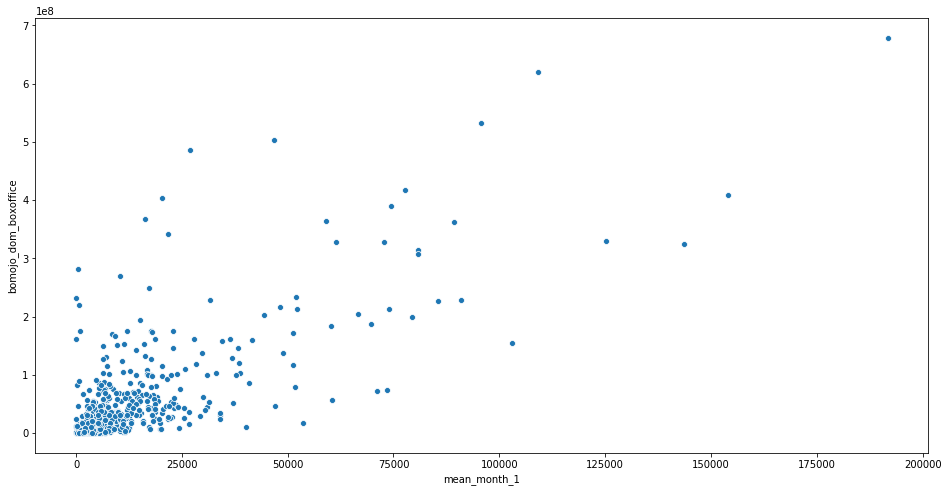

In [37]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='mean_month_1',y='bomojo_dom_boxoffice',data=df_bo_predictor)
plt.show()

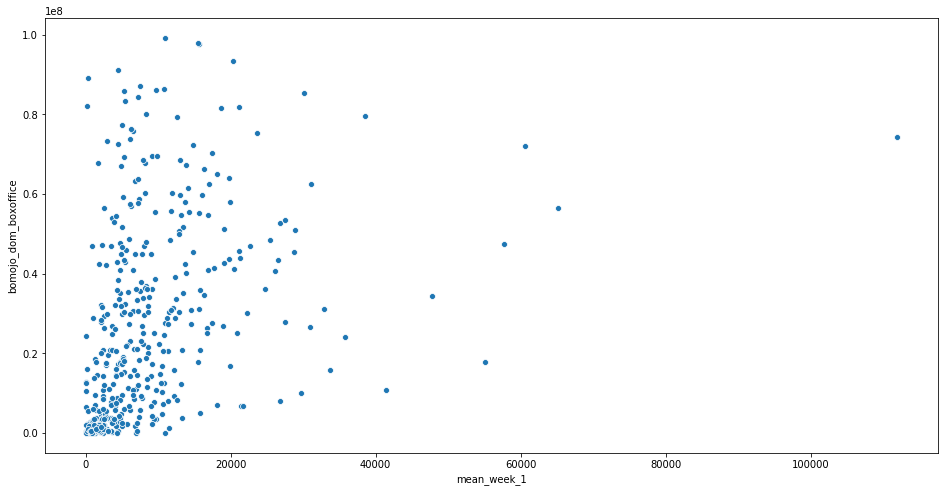

In [38]:
df_bo_predictor_smallmid = df_bo_predictor[df_bo_predictor['bomojo_dom_boxoffice'] < 100000000]

plt.figure(figsize=(16,8))
sns.scatterplot(x='mean_week_1',y='bomojo_dom_boxoffice',data=df_bo_predictor_smallmid)
plt.show()

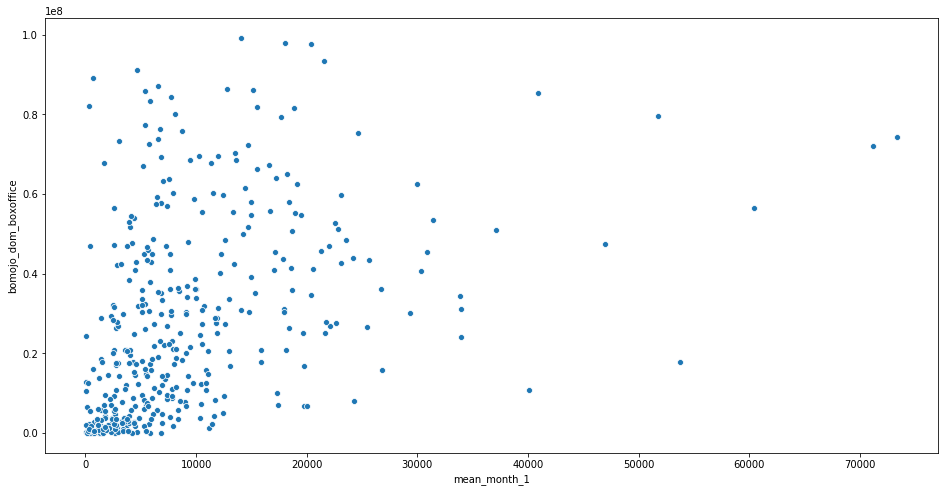

In [39]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='mean_month_1',y='bomojo_dom_boxoffice',data=df_bo_predictor_smallmid)
plt.show()

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


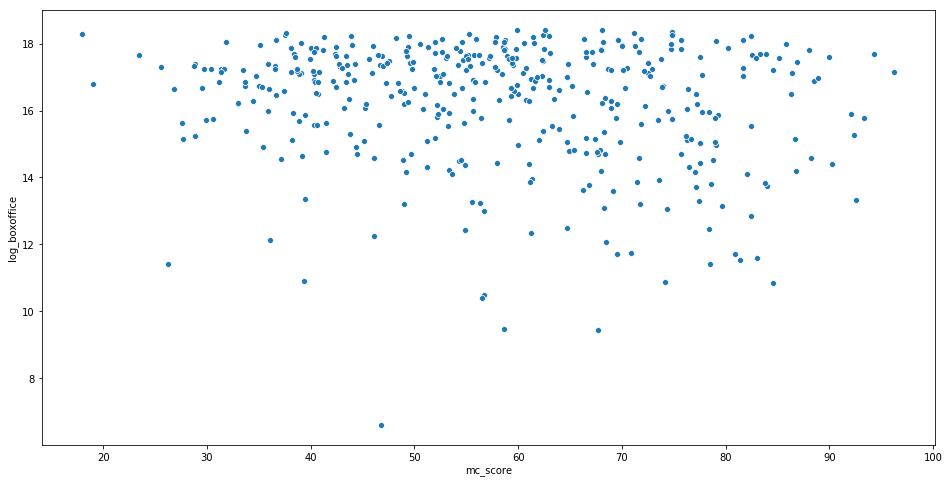

In [40]:
df_bo_predictor_smallmid['log_boxoffice'] = np.log(df_bo_predictor.bomojo_dom_boxoffice)

plt.figure(figsize=(16,8))
sns.scatterplot(x='mc_score',y='log_boxoffice',data=df_bo_predictor_smallmid)
plt.show()

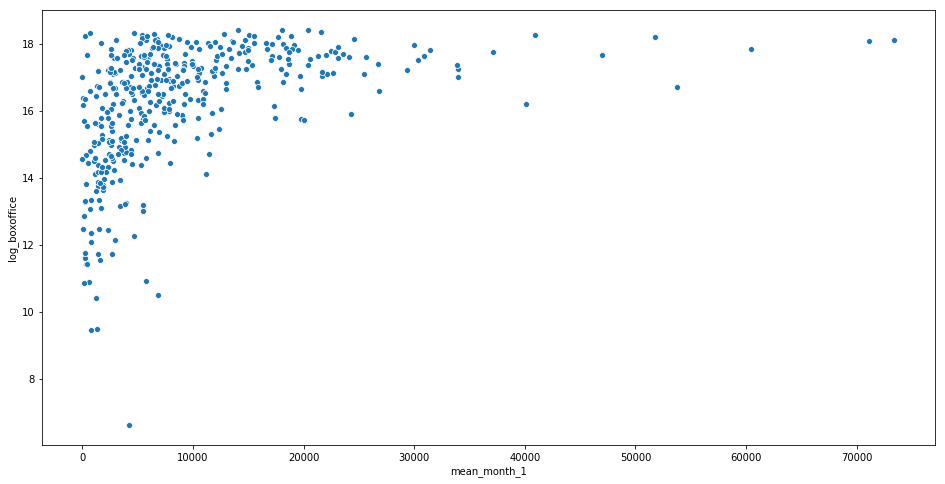

In [41]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='mean_month_1',y='log_boxoffice',data=df_bo_predictor_smallmid)
plt.show()

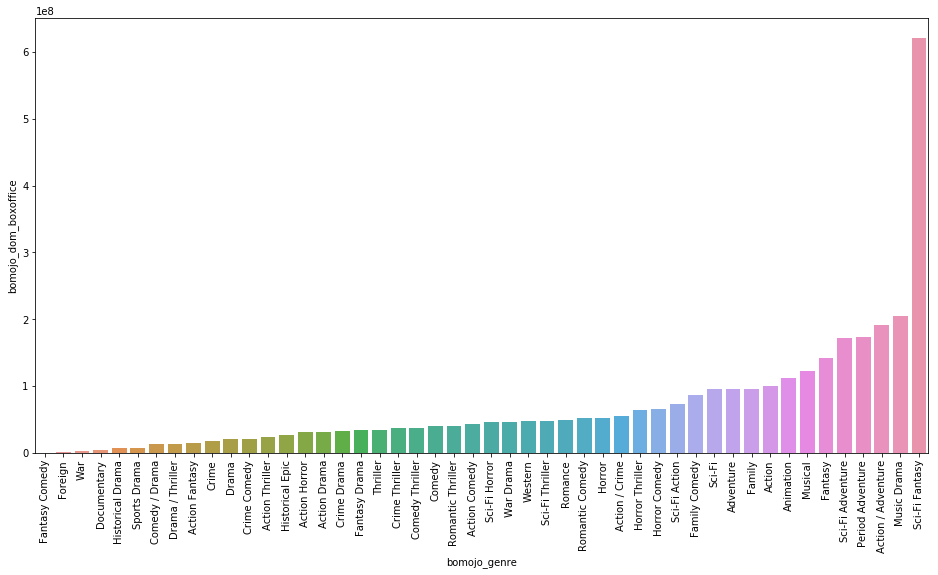

In [42]:
df_bo_predictor_genre = df_bo_predictor.groupby(['bomojo_genre'],as_index=False).mean()
order = df_bo_predictor_genre.sort_values(by='bomojo_dom_boxoffice')['bomojo_genre']

plt.figure(figsize=(16,8))
sns.barplot(x='bomojo_genre', y='bomojo_dom_boxoffice',data=df_bo_predictor_genre,order=order)
plt.xticks(rotation=90)
plt.show()

In [43]:
df_bo_predictor[df_bo_predictor['bomojo_genre'] == 'Sci-Fi Fantasy']

,wiki_url,Country,Directed by,Distributed by,Distributor,Genre,Produced by,Producer(s),Productioncompanies,Productioncompany,...,mean_month_6,max_month_6,median_month_6,std_month_6,max_mean_weekly_search_vol,mean_mean_weekly_search_vol,max_max_weekly_search_vol,mean_max_weekly_search_vol,mean_median_weekly_search_vol,max_median_weekly_search_vol
915,/wiki/Star_Wars:_The_Last_Jedi,United States,Rian Johnson,Walt Disney Studios|Motion Pictures,NaN,NaN,Kathleen Kennedy|Ram Bergman,NaN,NaN,Lucasfilm Ltd.,...,10884.966667,24958.0,9831.5,3293.200942,46189.428571,28116.342857,57971.0,33692.2,27530.4,44283.0


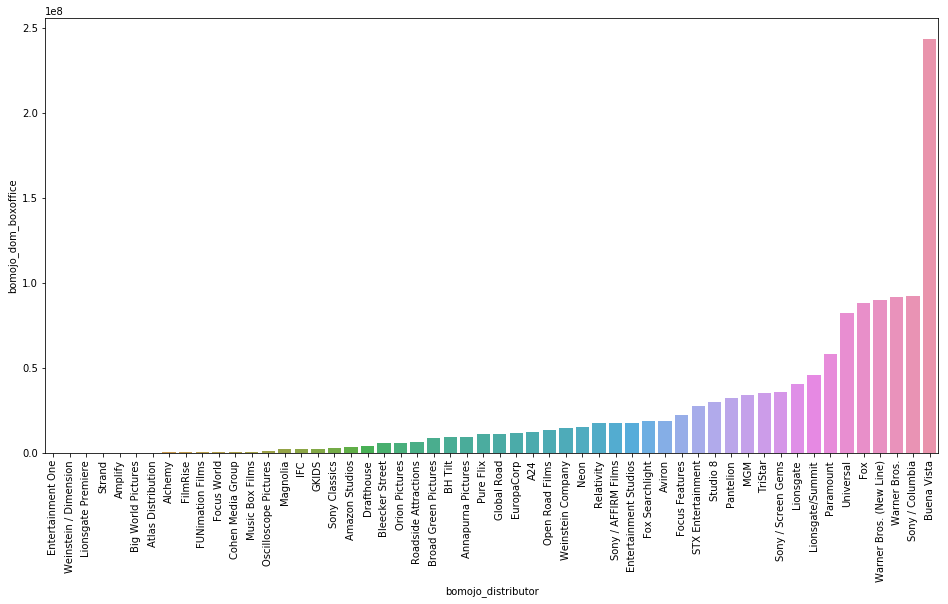

In [44]:
df_bo_predictor_distributor = df_bo_predictor.groupby(['bomojo_distributor'],as_index=False).mean()
order = df_bo_predictor_distributor.sort_values(by='bomojo_dom_boxoffice')['bomojo_distributor']

plt.figure(figsize=(16,8))
sns.barplot(x='bomojo_distributor', y='bomojo_dom_boxoffice',data=df_bo_predictor_distributor,order=order)
plt.xticks(rotation=90)
plt.show()

In [45]:
#create a category for distributors based on box office average size
df_bo_predictor_distributor['distrib_cat'] = pd.cut(df_bo_predictor_distributor['bomojo_dom_boxoffice'],
                                                       bins=[0,1000000,20000000,60000000,1000000000],
                                                       labels=['micro','small','mid','major'])

In [46]:
df_bo_predictor = df_bo_predictor.merge(df_bo_predictor_distributor[['bomojo_distributor','distrib_cat']],
                                        how='left',on='bomojo_distributor') 

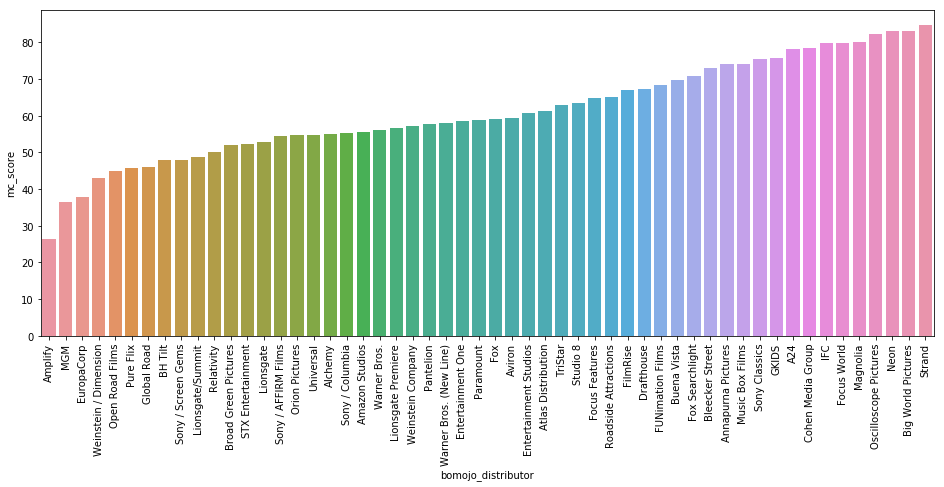

In [47]:
order = df_bo_predictor_distributor.sort_values(by='mc_score')['bomojo_distributor']

plt.figure(figsize=(16,6))
sns.barplot(x='bomojo_distributor', y='mc_score',data=df_bo_predictor_distributor,order=order)
plt.xticks(rotation=90)
plt.show()

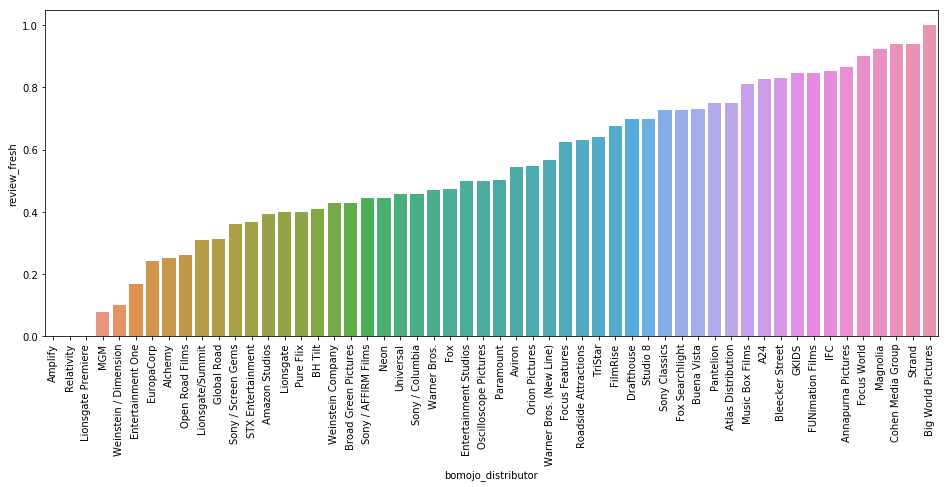

In [48]:
order = df_bo_predictor_distributor.sort_values(by='review_fresh')['bomojo_distributor']

plt.figure(figsize=(16,6))
sns.barplot(x='bomojo_distributor', y='review_fresh',data=df_bo_predictor_distributor,order=order)
plt.xticks(rotation=90)
plt.show()

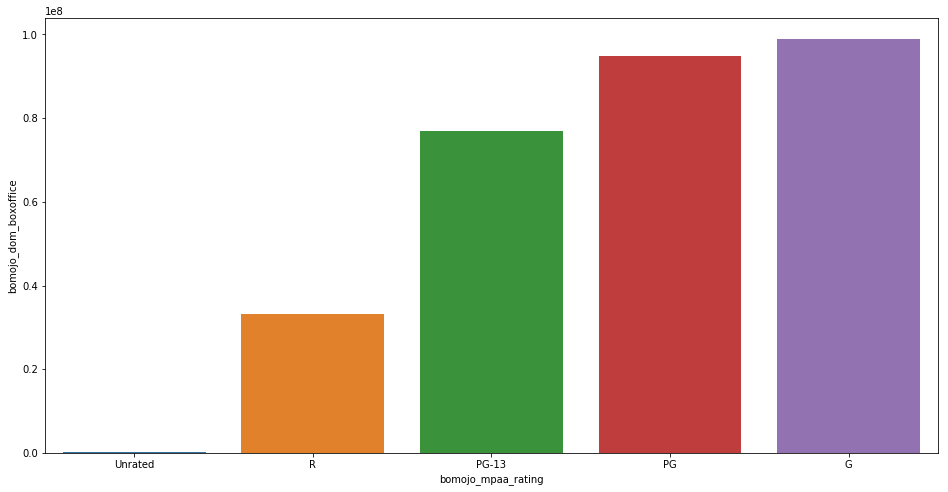

In [49]:
df_bo_predictor_mpaarating = df_bo_predictor.groupby(['bomojo_mpaa_rating'],as_index=False).mean()
order = df_bo_predictor_mpaarating.sort_values(by='bomojo_dom_boxoffice')['bomojo_mpaa_rating']

plt.figure(figsize=(16,8))
sns.barplot(x='bomojo_mpaa_rating', y='bomojo_dom_boxoffice',data=df_bo_predictor_mpaarating,order=order)
plt.show()

In [50]:
df_bo_predictor['log_boxoffice'] = np.log(df_bo_predictor.bomojo_dom_boxoffice)

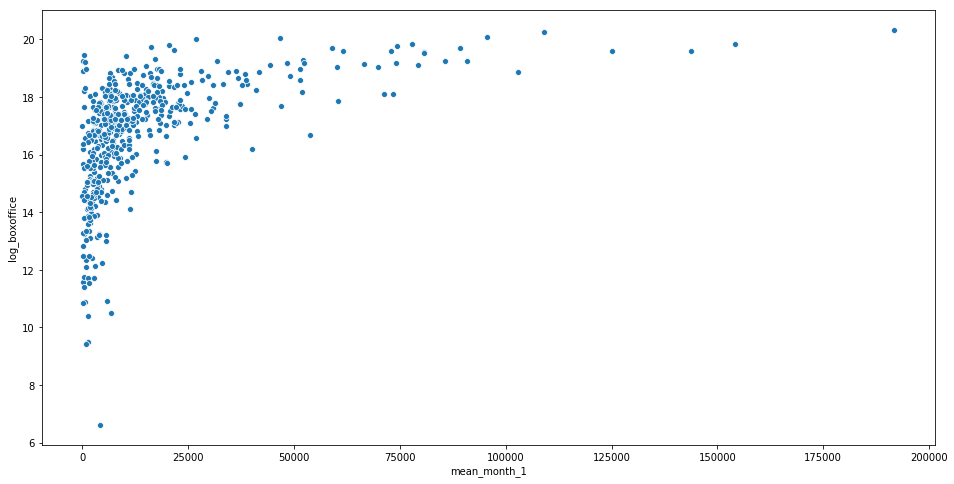

In [51]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='mean_month_1',y='log_boxoffice',data=df_bo_predictor)
plt.show()

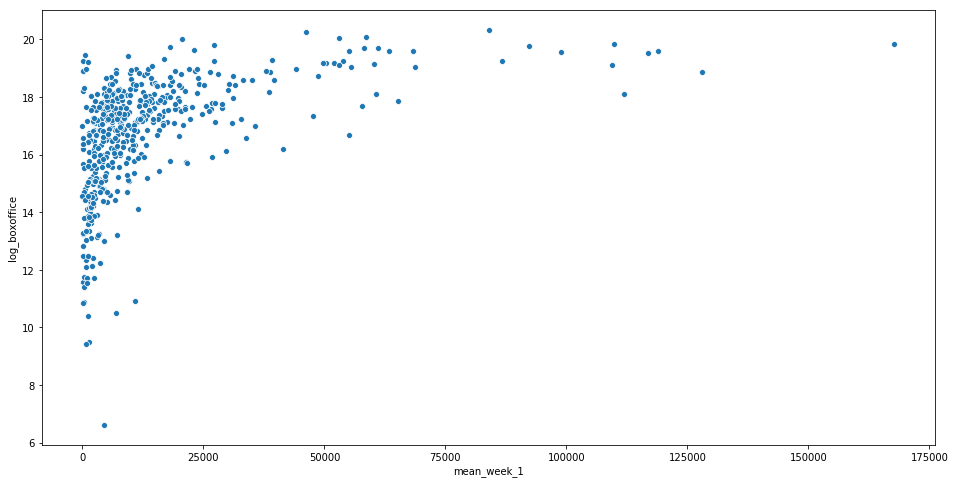

In [52]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='mean_week_1',y='log_boxoffice',data=df_bo_predictor)
plt.show()

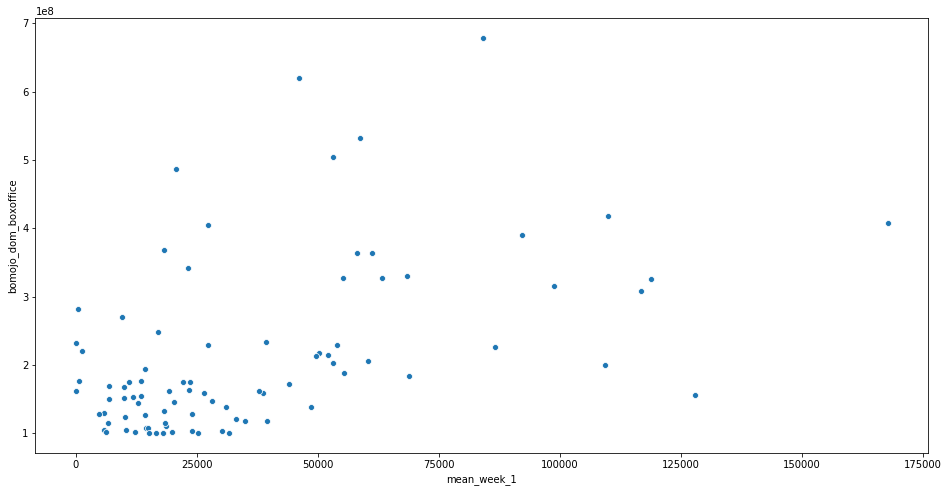

In [53]:
df_bo_predictor_big = df_bo_predictor[df_bo_predictor['bomojo_dom_boxoffice'] >= 100000000]

plt.figure(figsize=(16,8))
sns.scatterplot(x='mean_week_1',y='bomojo_dom_boxoffice',data=df_bo_predictor_big)
plt.show()

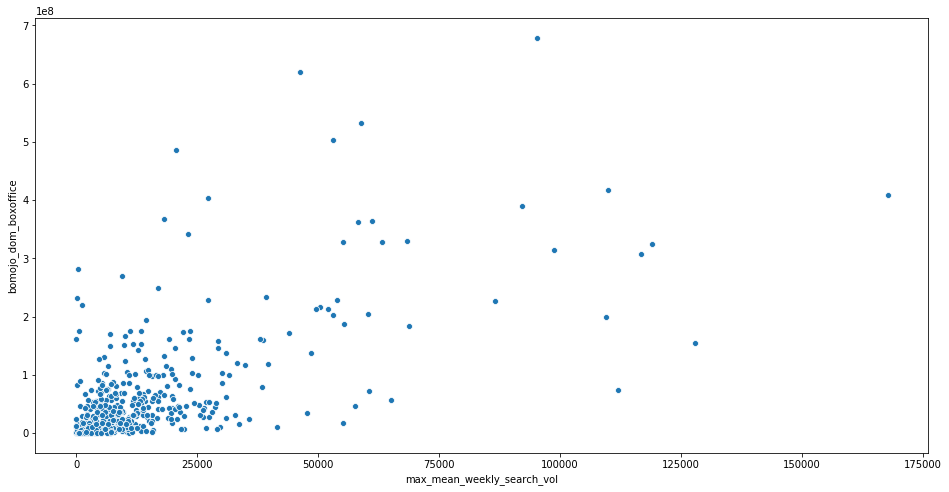

In [54]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='max_mean_weekly_search_vol',y='bomojo_dom_boxoffice',data=df_bo_predictor)
plt.show()

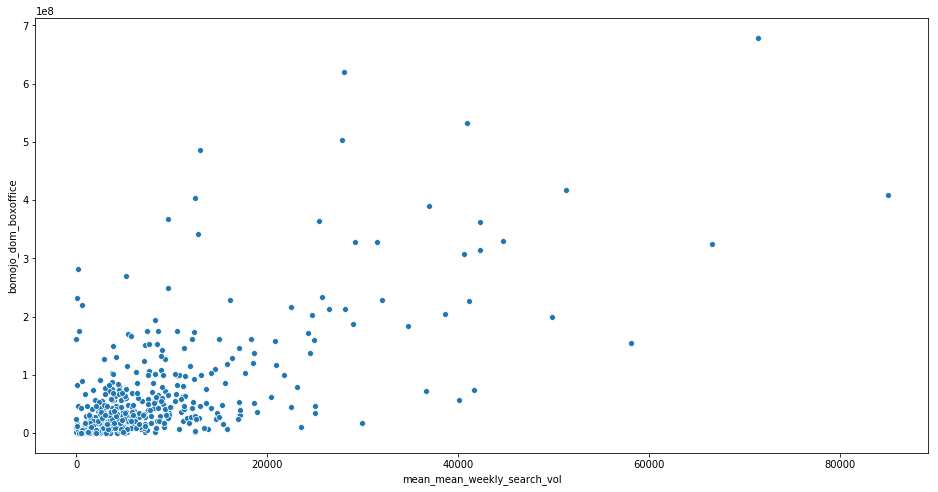

In [55]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='mean_mean_weekly_search_vol',y='bomojo_dom_boxoffice',data=df_bo_predictor)
plt.show()

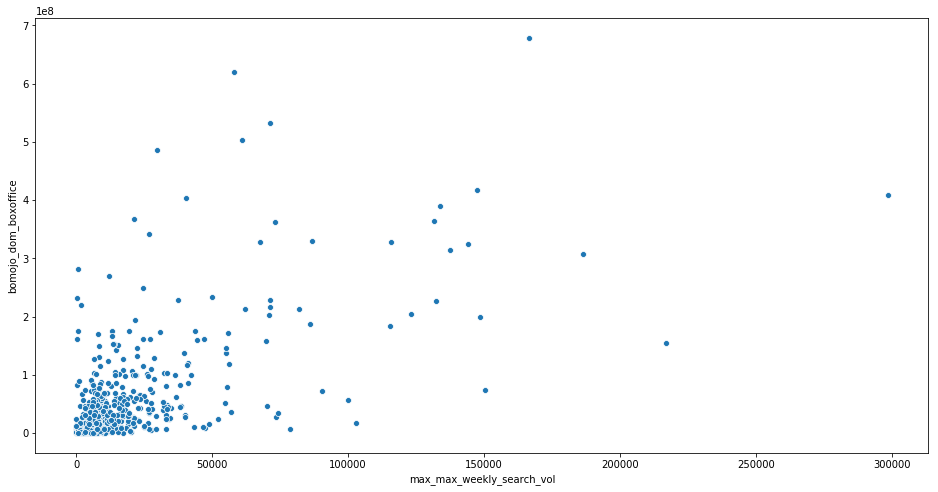

In [56]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='max_max_weekly_search_vol',y='bomojo_dom_boxoffice',data=df_bo_predictor)
plt.show()

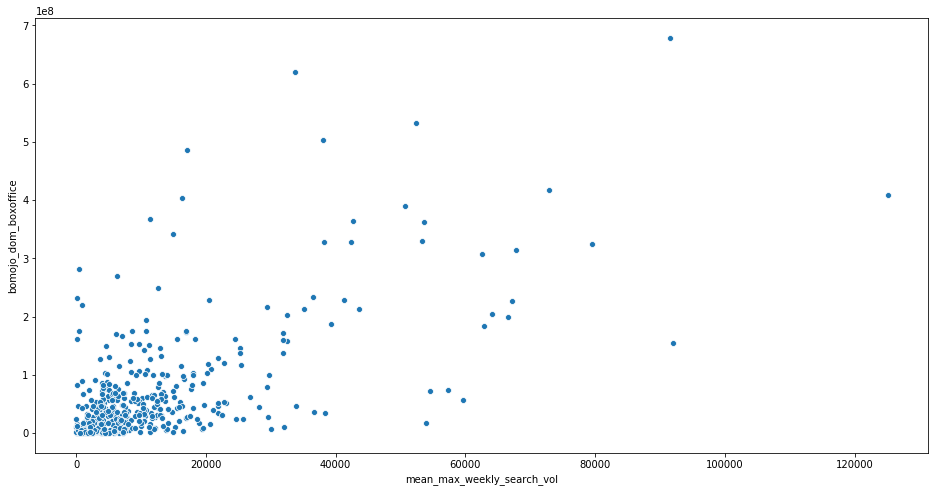

In [57]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='mean_max_weekly_search_vol',y='bomojo_dom_boxoffice',data=df_bo_predictor)
plt.show()

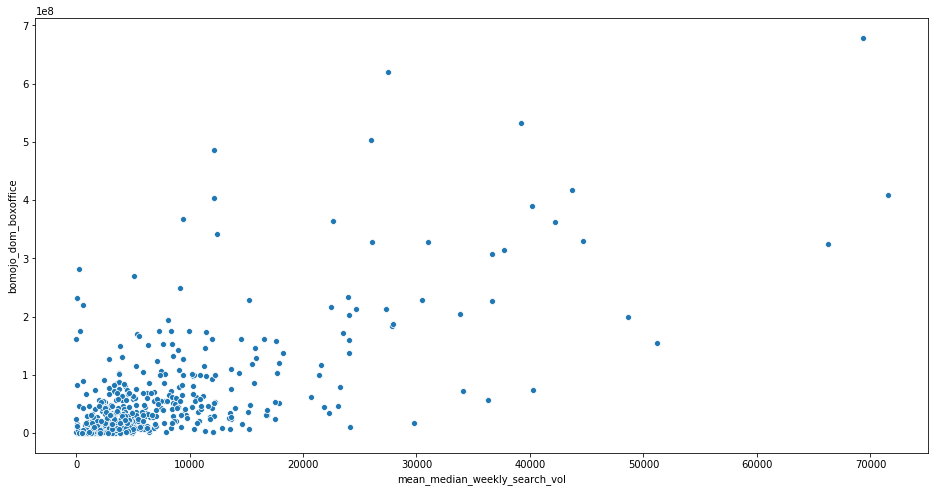

In [58]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='mean_median_weekly_search_vol',y='bomojo_dom_boxoffice',data=df_bo_predictor)
plt.show()

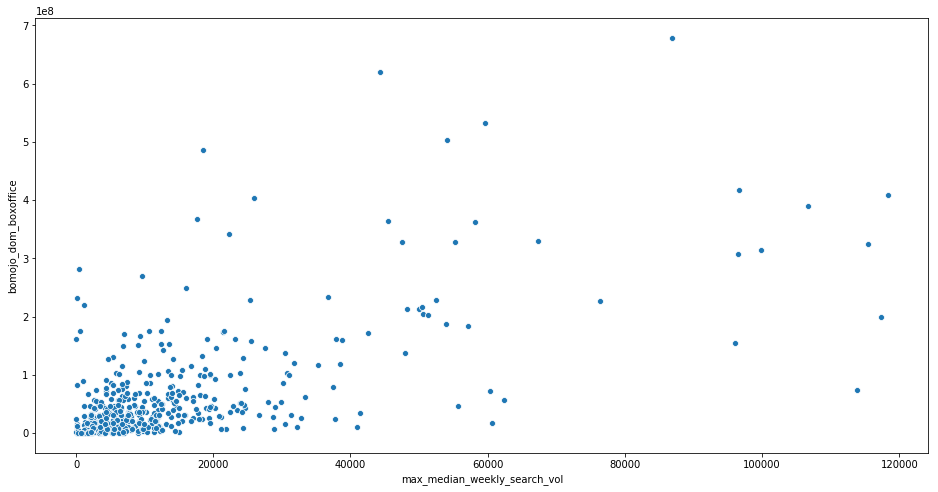

In [59]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='max_median_weekly_search_vol',y='bomojo_dom_boxoffice',data=df_bo_predictor)
plt.show()

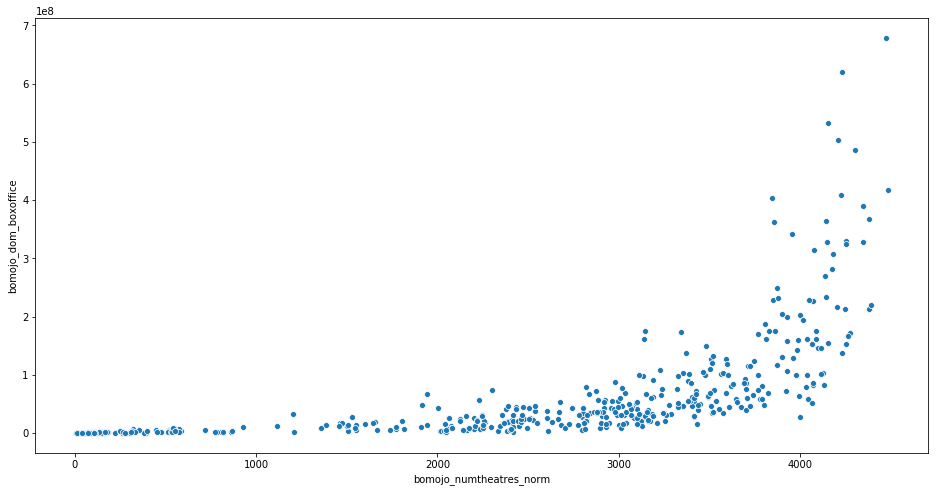

In [60]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='bomojo_numtheatres_norm',y='bomojo_dom_boxoffice',data=df_bo_predictor)
plt.show()

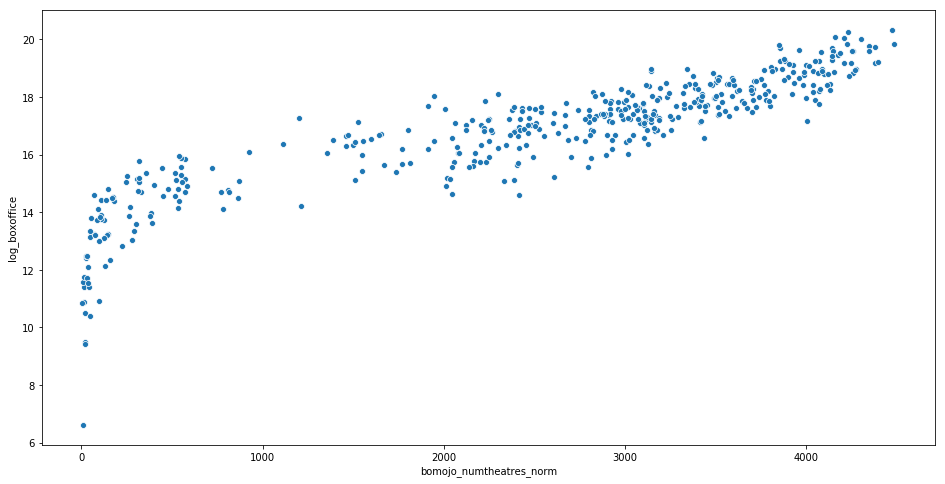

In [61]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='bomojo_numtheatres_norm',y='log_boxoffice',data=df_bo_predictor)
plt.show()

In [62]:
df_bo_predictor['log_numtheatres'] = np.log(df_bo_predictor.bomojo_numtheatres_norm)

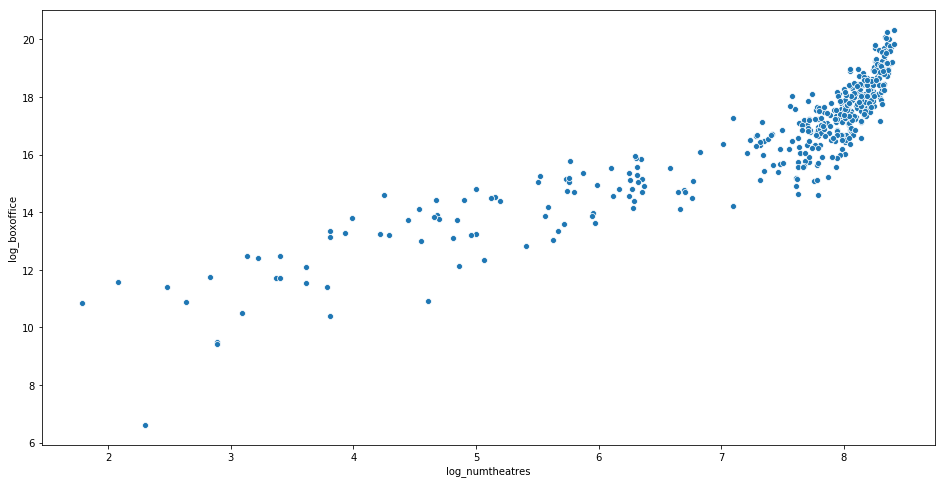

In [63]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='log_numtheatres',y='log_boxoffice',data=df_bo_predictor)
plt.show()

In [64]:
from datetime import datetime as dt

df_bo_predictor['month'] = df_bo_predictor.bomojo_dom_releasedate.dt.month

In [65]:
for column in df_bo_predictor.columns:
    missing = df_bo_predictor[column].isnull().sum()
    print(column, missing)

wiki_url 0
Country 1
Directed by 1
Distributed by 5
Distributor 494
Genre 494
Produced by 7
Producer(s) 494
Productioncompanies 296
Productioncompany 204
Productioncompany(s) 494
Release date 1
Released 494
Length 494
Running time 2
Website 494
Box office 3
Budget 45
Written by 258
bomojo_link 0
imdb_link 0
metacritic_link 0
rottentomatoes_link 0
wiki_title 0
org_wiki_url 0
clean_wiki_url 0
rt_url 0
review_fresh 0
mc_url 0
mc_score 0
bomojo_url 0
bomojo_title 0
bomojo_genre 0
bomojo_dom_releasedate 0
bomojo_mpaa_rating 0
bomojo_distributor 0
bomojo_dom_boxoffice 0
bomojo_ww_boxoffice 0
bomojo_opwkd_dom_boxoffice 494
bomojo_numtheatres 0
bomojo_numtheatres_norm 58
avg_search_vol 0
max_search_vol 0
median_search_vol 0
std_search_vol 0
title 0
mean_week_1 0
max_week_1 0
median_week_1 0
std_week_1 0
mean_week_2 0
max_week_2 0
median_week_2 0
std_week_2 0
mean_week_3 0
max_week_3 0
median_week_3 0
std_week_3 0
mean_week_4 0
max_week_4 0
median_week_4 0
std_week_4 0
mean_week_5 0
max_week_5 

In [66]:
df_bo_predictor = df_bo_predictor.dropna(subset=['bomojo_numtheatres_norm'])

In [67]:
X = df_bo_predictor[['review_fresh', 'bomojo_genre', 'bomojo_mpaa_rating', 
#                      'bomojo_numtheatres_norm',
                     'avg_search_vol', 'max_search_vol',
#                      'median_search_vol', 'std_search_vol', 
                     'mean_week_1', 'mean_month_1',
                     'max_mean_weekly_search_vol', 'mean_mean_weekly_search_vol',
                     'max_max_weekly_search_vol', 'mean_max_weekly_search_vol',
                     'mean_median_weekly_search_vol', 'max_median_weekly_search_vol',
                     'distrib_cat', 'month',
                    'log_numtheatres'
                    ]]
Y = df_bo_predictor.log_boxoffice
X = pd.get_dummies(X)

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

### Multivariable Linear regression

In [69]:
lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

print('Coefficients: \n', lr.coef_)
print('Intercept: \n', lr.intercept_)
print('R-squared: \n', lr.score(X_train, y_train))

Coefficients: 
 [ 1.07743660e+00  9.92828967e-05  3.87624274e-07 -1.71921566e-05
 -8.32345010e-06  2.56385927e-05  1.62650077e-04 -5.83841237e-07
 -7.28339954e-05 -9.65166834e-05  1.04799407e-05  1.44600019e-02
  1.08198803e+00  1.31954593e-01  5.73097254e-01  5.06356430e-01
  3.94397899e-01 -7.98048407e-02 -3.95580861e-02 -1.53210777e-14
 -3.22461306e-02  1.49183493e-01  3.14592883e-02  1.43814953e-01
  1.97417290e-01 -3.46711188e-01 -4.99600361e-16 -6.16919841e-01
  3.75348514e-02 -5.07434213e-01 -3.29510139e-02  1.20571675e-01
  1.02586361e-01  3.82094429e-01  6.32109843e-01  1.93267649e-01
 -2.28067318e-02  6.66133815e-16 -3.33066907e-16 -2.77555756e-17
  7.70898374e-02 -3.15189161e-01 -2.31907408e-01  4.85722573e-16
 -6.17244932e-01  4.99076371e-01  2.67829183e-01  1.06254093e-01
 -9.71445147e-17  1.43897937e-02 -8.40644185e-02  1.11181991e-01
  7.64873942e-01 -2.11854859e-01 -1.26651169e+00 -6.61319606e-01
 -5.73260981e-02  8.35847903e-02 -3.96275789e-01  4.45335815e-02
 -1.16907

In [70]:
y_pred = lr.predict(X_test)

In [71]:
from sklearn import metrics

print('Mean Absolute Error: %.1f' % metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error: %.1f' % metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error: %.1f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 

Mean Absolute Error: 0.6
Mean Squared Error: 0.7
Root Mean Squared Error: 0.8


In [72]:
compare_df = pd.DataFrame({'actual_boxoffice':np.exp(y_test),
                          'predicted_boxoffice':np.exp(y_pred)},
                         columns=['actual_boxoffice','predicted_boxoffice'])

In [73]:
compare_df['difference'] = abs(compare_df['actual_boxoffice'] - compare_df['predicted_boxoffice'])
compare_df['difference %'] = abs(compare_df['predicted_boxoffice'] / compare_df['actual_boxoffice'] - 1) * 100

In [74]:
# look at instances where we predicted greater or less than 75% of actual box office, try to fix
big_misses = compare_df[compare_df['difference %'] > 75]
big_misses

,actual_boxoffice,predicted_boxoffice,difference,difference %
326,624332.0,1.154229e+06,5.298967e+05,84.874179
417,31445012.0,6.809222e+07,3.664721e+07,116.543793
366,6069605.0,1.380226e+07,7.732658e+06,127.399693
424,50072235.0,1.194463e+08,6.937408e+07,138.548007
137,1978592.0,4.957484e+06,2.978892e+06,150.556137
56,2583301.0,4.527804e+06,1.944503e+06,75.272035
31,3591417.0,3.279302e+07,2.920160e+07,813.094154
221,12544.0,1.062161e+05,9.367212e+04,746.748372
485,15951040.0,6.522554e+07,4.927450e+07,308.910893
440,145443742.0,2.754172e+07,1.179020e+08,81.063662


In [76]:
df_bo_predictor.loc[big_misses.index]

,wiki_url,Country,Directed by,Distributed by,Distributor,Genre,Produced by,Producer(s),Productioncompanies,Productioncompany,...,max_mean_weekly_search_vol,mean_mean_weekly_search_vol,max_max_weekly_search_vol,mean_max_weekly_search_vol,mean_median_weekly_search_vol,max_median_weekly_search_vol,distrib_cat,log_boxoffice,log_numtheatres,month
326,/wiki/The_Only_Living_Boy_in_New_York_(film),United States,Marc Webb,Roadside Attractions|Amazon Studios,NaN,NaN,Albert Berger|Ron Yerxa,NaN,NaN,Amazon Studios|Big Indie Pictures|Bona Fide Pr...,...,1363.142857,1006.657143,2036.0,1252.4,937.2,1079.0,small,13.344438,5.666427,8
417,/wiki/Adrift_(2018_film),United States,Baltasar Kormákur,STX Films,NaN,NaN,Baltasar Kormákur|Aaron Kandell|Jordan Kandell...,NaN,NaN,STX Films|Lakeshore Entertainment|H. Brothers|...,...,12019.142857,7051.057143,15082.0,9635.8,6670.4,11601.0,mid,17.263751,8.011355,6
366,/wiki/Just_Getting_Started_(film),United States,Ron Shelton,Broad Green Pictures,NaN,NaN,Bill Gerber|Steve Richards,NaN,NaN,Entertainment One,...,1086.714286,629.971429,1305.0,742.4,649.6,1091.0,small,15.618804,7.678326,12
424,/wiki/Sicario:_Day_of_the_Soldado,United States,Stefano Sollima,Columbia Pictures|Lionsgate|(Some Countries),NaN,NaN,Basil Iwanyk|Edward L. McDonnell|Molly Smith|T...,NaN,NaN,Black Label Media|Thunder Road Pictures,...,12870.285714,7560.314286,18834.0,10259.2,7264.0,12350.0,major,17.728977,8.024535,6
137,/wiki/Demolition_(2015_film),United States,Jean-Marc Vallée,Fox Searchlight Pictures,NaN,NaN,Lianne Halfon|Russ Smith|Molly Smith|Trent Luc...,NaN,NaN,Black Label Media|Sidney Kimmel Entertainment|...,...,2569.285714,1508.228571,3392.0,2084.0,1500.6,2977.0,small,14.497896,6.759255,4
56,/wiki/Captive_(2015_film),United States,Jerry Jameson,Paramount Pictures,NaN,NaN,Lucas Akoskin|Terry Botwick|Alex Garcia|David ...,NaN,BN Films|Brightside Entertainment|1019 Enterta...,NaN,...,4486.285714,1960.971429,8357.0,3029.8,1900.6,4282.0,mid,14.764579,6.693324,9
31,/wiki/We_Are_Your_Friends_(film),United States|United Kingdom|France,Max Joseph,StudioCanal|Warner Bros.,NaN,NaN,Tim Bevan|Eric Fellner|Liza Chasin,NaN,StudioCanal|Anton Capital Entertainment|Workin...,NaN,...,9685.285714,5161.514286,10906.0,7021.8,5012.6,9741.0,major,15.094057,7.754910,8
221,/wiki/The_Monster_(2016_film),United States,Bryan Bertino,A24,NaN,NaN,Bryan Bertino|Adrienne Biddle|Aaron L. Ginsberg,NaN,NaN,Atlas Independent|Unbroken Pictures,...,1252.142857,820.371429,4810.0,1894.4,568.2,1109.0,small,9.436998,2.890372,11
485,/wiki/Mortal_Engines_(film),New Zealand|United States,Christian Rivers,Universal Pictures,NaN,NaN,Zane Weiner|Amanda Walker|Deborah Forte|Fran W...,NaN,NaN,Universal Pictures|[2]|Media Rights Capital|[2...,...,33756.571429,15445.085714,48702.0,20649.6,14599.6,30487.0,major,16.585035,8.040125,12
440,/wiki/The_Meg,China|United States,Jon Turteltaub,Warner Bros. Pictures,NaN,NaN,Lorenzo di Bonaventura|Colin Wilson|Belle Avery,NaN,NaN,Warner Bros. Pictures|Gravity Pictures|Flagshi...,...,20354.285714,11299.657143,22565.0,12902.4,11324.6,20392.0,major,18.795300,8.323123,8


Major issue identifying small / horror films, a few overachievers. The miss on Spider-verse is super interesting. I think it's seen as a film that has done well, but based on my prediction should have done even better. 

### Write-up

First off, I think the real challenge / lesson learned here was scraping using beautifulsoup and how to build a class to run the scraping. I plan on coming back and creating a class for my cleaning of the data as well, but I think I will need to plan out my cleaning better for how it will ingest the dataframes / csvs from the scraper and then run. 

I faced a lot of challenges in getting this data useable. After battling with bs4, funky urls coming from my sources, and how to get everything into the right format and into dataframes, I suffered the worst setback of all. I had planned and am able to get data for films as far back as I want to go; I had planned on going back to 2000 at least. Unfortunately, the wikipedia API to get pageview data for each title only goes back to July 2015. I didn't realize this until I was struggling to calculate average search volume from the release date of films from the 2000s. I kept getting errors even though it worked on the films I was testing, all which happened to be fairly recent. Older data is available through a legacy wikimedia stats package, but it's not clear if there's an API for it. I will need to do more research to fully fix.

As a result, my dataset went from 2k+ to ~500 films. In looking at the films where my prediction is vastly different from the actual box office, it's plain to see how the smaller sample size hurts me. The model is very poor in predicting large films (the dataset does not have enough films that make over $100M to properly model), small horror films (especially of the Blumhouse variety). My thought is to maybe bring the distributor or production company name from wikipedia into the model with perhaps a token vectorizer to capture the more long tail / niche films. 

Another important finding, one which I would like to dive into deeper, is the linear relationship with the many features I've created and my target variable.

Finally, I'd like to take this data and build a few other models out of it to determine whether I can get better results from the data for other target variables. The other target variables I'd like to model are opening weekend box office and opening weekend to full run of the film (known commonly as the film multiple). I'd also like to experiment how early I can predict my target variable with my search volume data without giving up too much accuracy. 